<h2>1 - Data Preperation<h2>

<h3>1.1 - Importing Data/Libraries</h3>

<p> We begin by importing the stock and reddit data we have gathered.</p>

In [1180]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from copy import deepcopy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import figure
from Analyzer import Analyzer
from LSTM import LSTM

ImportError: cannot import name 'LSTM' from 'LSTM' (c:\Users\Anderson\Documents\GitHub\Stock-Lstm\Short Run Prediction\LSTM.py)

In [ ]:
df1 = pd.read_json('./Datasets/generated_data_Economics.json')
df2 = pd.read_csv('./Datasets/VOO.csv')

In [ ]:
#Subreddit Data
df1.head()

In [ ]:
#Stock Data
df2.head()

<h3>1.2 - Preparing The Subreddit Sentiment Data </h3>

In [ ]:
#Bring out date/time data from index
df1.reset_index(inplace=True)
df1['index'] = pd.to_datetime(df1['index'])
df1['date'] = df1['index'].dt.date

#Group times and their corresponding sentiment data into a list by day
df1['time'] = df1['index']
df1 = df1.groupby('date').agg(list)
df1.reset_index(inplace=True)

#Create final dataframe
df1 = df1[['date', 'time', 'Economics']]
df1.head()

<h3>1.3 - Preparing The Stock Price Data<h3>

In [ ]:
#Bring out date/time data from index
df2['date_time'] = pd.to_datetime(df2['Unnamed: 0'])
df2['date'] = df2['date_time'].dt.date
df2['time'] = df2['date_time'].dt.tz_localize(None)

#Group times and their corresponding price data into a list by day
df2 = df2.groupby('date').agg(list)
df2.reset_index(inplace=True)

#Create Final Dataframe
df2.rename(columns={'Adj Close': 'price'}, inplace=True)
df2 = df2[['price', 'date', 'time']]
df2.head(5)


<h3>1.4 - Merging The Sentiment Data And Stock Price Data<h3>

In [ ]:
#merge stock/sentiment data according to the date value
df = pd.merge(df1, df2, how='outer', on='date')
df['date'] =  pd.to_datetime(df['date'])
df.rename(columns={'time_x': 'sentiment_time', 'time_y':'stock_time'}, inplace=True)

#get rid of rows that have no sentiment data
df.dropna(inplace=True)
df['na'] = np.nan
df.head()

<h3>1.5 - Determining Percent Change In Price<h3>

In [ ]:
def generate_price_dif(row):
    prices = np.asarray(row['price'])
    price_shift = np.asarray([row['price'][-1]] + row['price'][:-1])
    delta_price = prices - price_shift
    return delta_price

#Create the price difference/percent change columns using the above function
df['price_diff']  = df.apply(lambda row: generate_price_dif(row), axis=1)
df['percent_change'] = df.apply(lambda row: (row['price_diff']/np.asarray(row['price'])) * 100, axis= 1)

df.head()

<h2>2 - Visualizing Trends In News Sentiment and Stock Prices</h2>

<p>Visualizing the data should reveal trends in the prices that make be unintuitive given large sets of numbers. This should provide us with a solid basis for attempting to explore correlations in stock prices and news sentiment.</p>

<h3>2.1 - Plotting Sentiment Versus Price</h3>

<p>We begin by exploring the intesnity of sentiment per minute with data to the daily graph of our given stock.</p>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
myFmt = mdates.DateFormatter('%H%:%M:%S')

class Analyzer:
    """
    Generator class which contains methods to generate data from subreddits/stock prices.
    Initializes with:
        - Subreddits: a list of subreddit titles where each title is a string
        - Dataframe: a pandas dataframe containing the stock prices per time interval
        - 
    """

    def __init__(self, subreddits, dataframe):
        self.subreddits = subreddits
        self.dataframe = dataframe
        self.df_dict = self.generate_daily_full(subreddits, dataframe)
        self.complete_markov = {subreddit:[] for subreddit in self.subreddits}
        self.combined_df_dict = None



    def convert(self, row, subreddit):
        lst = []
        for dct in row.loc[subreddit]:
            lst.append([dct])

        return lst
        


    def generate_daily_data(self, index, subreddit):
        """
        Creates a dataframe that is the result of merging the stock prices per time period
        and the subreddit specific data
        Inputs:
            - index: the index of the row being used to generate data
        Outputs:
            - Returns a pandas dataframe of daily subreddit/stock price data
        """
        
        #create a dictionary with a time key that has every minute ina 24 hour period
        d = self.dataframe.iloc[index][['date', 'na']].to_dict()
        d['time'] = pd.date_range(self.dataframe['date'].iat[index], freq='Min', periods=60*24, name='date')
        
        #create an empty dataframe with the index as the generated time
        df = pd.DataFrame(d)
        df.set_index(df['time'], inplace = True)
        df = df[[]]

        #create dataframe for each column of stock data we want time series for -> index is stock_time
        price_time_df = pd.DataFrame(self.dataframe.iloc[index]['price'], 
                                    index = self.dataframe.iloc[index]['stock_time'], 
                                    columns=['price'])

        percent_change_df = pd.DataFrame(self.dataframe.iloc[index]['percent_change'], 
                                        index = self.dataframe.iloc[index]['stock_time'], 
                                        columns=['percent_change'])
        
        #store created dataframes in a list to later be merged into one dataframe
        lst = [price_time_df, percent_change_df]

        #create dataframes of sentiment_data -> index is sentiment_time
        for subreddit in self.subreddits:
            reddit_df = pd.DataFrame(self.dataframe.iloc[index][subreddit], 
                                    index = self.dataframe.iloc[index]['sentiment_time'], 
                                    columns=['sentiment']).reset_index()

            sentiment_time_df = pd.json_normalize(reddit_df['sentiment'])
            sentiment_time_df['index'] = reddit_df['index']
            sentiment_time_df.set_index(['index'], inplace=True)
            lst.append(sentiment_time_df)
        
        #Create new Dataframe by joining all of the generated dataframes
        joined_df = df.join(lst)
        joined_df.reset_index(inplace=True)
        joined_df = joined_df.dropna(subset=['price'])
        joined_df.index = joined_df.pop('time')
        #pd.to_datetime(joined_df['time'])
        
        return joined_df



    def generate_daily_full(self, subreddits, dataframe):
        dct = {}
        df = pd.DataFrame()
        for subreddit in subreddits:
            dataframe[subreddit] = dataframe.apply(lambda row: self.convert(row, subreddit), axis = 1)
            lst = [self.generate_daily_data(i, subreddit) for i in range(len(dataframe))]
            for i in lst:
                df=pd.concat([df, i], ignore_index=False)
            df = df.fillna(method='ffill').dropna()
            dct[subreddit] = df
        return dct



    def markov_chain_data(self):
        """
        Adds a column to the daily dataframes indicating the markov bin the time interval falls into
        """
        for subreddit in self.subreddits:
            for df in self.df_dict[subreddit]:

                #generates a numpy array populated with values that correspond to precent changes -> new markov_bins column
                df['markov_bins'] = np.where(
                    (df['percent_change'] < -.1), 0, np.where(
                        ((df['percent_change'] > -.1) & (df['percent_change'] < 0)), 1, np.where(
                            ((df['percent_change'] < .1) & (df['percent_change'] > 0)), 2, np.where(
                                (df['percent_change'] > .1), 3, np.nan
                            ))))

                self.complete_markov[subreddit] += list(df.markov_bins.dropna())


    def plot_markov_hist(self, start_day, end_day):

        #iterate through the range of start_day and end_day -> create a dictionary where the key is bin # and key is the count
        for day in range(start_day, end_day+1):
            lst = np.array(self.df_dict['Economics'][day].markov_bins.dropna())
            unique, counts = np.unique(lst, return_counts=True)
            dct = dict(zip(unique,counts))
            plt.bar(unique, counts)
            plt.show()
            


    def plot_subreddits_day(self, subreddits, plot_args, start_day, end_day, percent_change = False):
        colors = {'neg': 'red','pos':'green', 'neu': 'blue'}
        for day in range(start_day, end_day+1): 
            for subreddit in subreddits:
                fig,ax = plt.subplots()
                if not percent_change:
                    ax.plot(self.df_dict[subreddit][day].time, self.df_dict[subreddit][day].price, color="black",)
                else:
                    ax.plot(self.df_dict[subreddit][day].time, self.df_dict[subreddit][day].percent_change, color="blue")
                    ax.set_ylim([-.3, .3])

                #ax.xaxis.set_major_formatter(myFmt)

                # set x-axis label
                ax.set_xlabel("Time", fontsize = 14)
                # set y-axis label
                ax.set_ylabel("Price", color="red", fontsize=14)
                ax2=ax.twinx()
                # make a plot with different y-axis using second axis object
                for arg in plot_args:
                    ax2.bar(self.df_dict[subreddit][day].time, self.df_dict[subreddit][day][arg] ,color=colors[arg], width = .002)
                ax2.set_ylabel("Sentiment",color="black",fontsize=14)
                fig.set_figwidth(15)
                fig.set_figheight(5)
                plt.show()


    def generate_train_test(self, index):
        """
        
        """
        for subreddit in self.subreddits:
            df_temp = pd.concat(self.df_dict[subreddit])
            for column in df_temp.columns:
                if column != 'time':
                    df_temp[column].fillna(value = df_temp[column].mean(), inplace=True)
            n = len(df_temp)
            
            train_df = df_temp[0:int(n*.7)]
            train_x = train_df.drop(['time', 'price'], axis=1)
            train_y = train_df[['price']]

            val_df = df_temp[int(n*.7):int(n*.9)]
            val_x = val_df.drop(['time', 'price'], axis=1)
            val_y = val_df[['price']]
            
            test_df = df_temp[int(n*.9):]
            test_x = test_df.drop(['time', 'price'], axis=1)
            test_y = test_df[['price']]

        return [(train_x, train_y), (val_x, val_y), (test_x, test_y)]

In [ ]:
analyzer = Analyzer(['Economics'], df)

<p>Now lets explore the relationship between change in price and the sentiment intensities</p>

In [ ]:
analyzer.df_dict['Economics']

,price,percent_change,0
time,,,
2022-09-01 12:40:00,359.350006,-0.027830,"{'polarity': 0.4, 'subjectivity': 0.7000000000..."
2022-09-01 12:41:00,359.459991,0.030597,"{'polarity': 0.4, 'subjectivity': 0.7000000000..."
2022-09-01 12:42:00,359.450012,-0.002776,"{'polarity': 0.5, 'subjectivity': 0.6000000000..."
2022-09-01 12:43:00,359.468994,0.005281,"{'polarity': 0.1, 'subjectivity': 0.4, 'compou..."
2022-09-01 12:44:00,359.619995,0.041989,"{'polarity': 0.5, 'subjectivity': 0.925, 'comp..."
...,...,...,...
2022-09-23 15:55:00,338.980011,-0.100300,"{'polarity': 0.0, 'subjectivity': 0.0, 'compou..."
2022-09-23 15:56:00,338.799988,-0.053136,"{'polarity': 0.0, 'subjectivity': 0.0, 'compou..."
2022-09-23 15:57:00,338.920013,0.035414,"{'polarity': 0.0, 'subjectivity': 0.0, 'compou..."


KeyError: 2

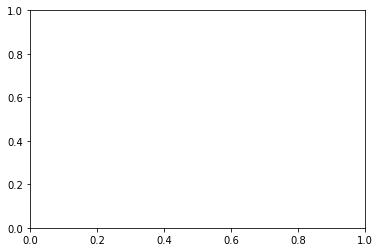

In [ ]:
#analyzer.plot_subreddits_day(['Economics'], ['neg', 'pos'], 2, 5)

<h3>Initial Hypothesis</h3>
<p>blah blah blah</p>

<h2>3 - Markov Chains<h2>

In [ ]:
analyzer.markov_chain_data()

TypeError: string indices must be integers

<h3>3.1 - Plotting Hist</h3>

In [ ]:
analyzer.plot_markov_hist(0,2)

AttributeError: 'Series' object has no attribute 'markov_bins'

<h3>3.2 - Nth Degree Markov Chains<h3>

In [ ]:
from collections import defaultdict
import random

class Markov(Analyzer):
    
    def __init__(self):
        self.chain = None
        self.predictions = None


    def generate_chain(self, degree, data):

        #nested default dict
        dct = defaultdict(lambda: defaultdict(int))    

        #generate previously seen states of length degree -> key into state slice then add one to the state at the index after slice
        for i in range((len(data) - degree - 1)):
            r = degree + i
            slice = tuple(data[i: r])
            dct[slice][data[r]] += 1

        #convert to frequencies
        for key, value in dct.items():
            sums = sum(value.values())
            for key2, value2 in value.items():
                dct[key][key2]= value2/sums
                dct[key] = dict(dct[key])
        
        self.chain = dict(dct)


    def predict(self, last, num):
        states = []
        
        for _step in range(num):
            rand_list = [] #contains the numbers 0, 1, 2, 3 in their proper frequency
            weights = []
            
            if tuple(last) not in self.chain.keys(): #check if the key exists in dict
                rand_list = [0,1,2,3]
                weights = [.25, .25, .25, .25]
                    
            else: 
                for key, value in self.chain[tuple(last)].items():
                    rand_list.append(key)
                    weights.append(value)

            #randomly pick from list of elements - equivalent to a weighted average
            state = np.random.choice(rand_list, 1, p=weights)[0]

            states.append(state)
            last = last[1:] #shift last to the right in order to maintain order size
            last.append(state)

        self.predictions = np.asarray(states)
        

    def mse(self, expected):
        expected = np.asarray(expected)
        return np.sum(((self.predictions - expected)**2))/len(expected)

    def accuracy(self, expected):
        return (self.predictions == np.asarray(expected)).mean()


    def run(self, train, test, degree, trials):
        #initialize error as 0 and then add as trials progress
        cumulative_accuracy = 0
        error = 0
        for _trial in range(trials):
            self.generate_chain(degree, train)
            self.predict(test[:degree], len(test) - degree)
            cumulative_accuracy += self.accuracy(test[degree:])
            error += self.mse(test[degree:])
         
        return cumulative_accuracy/trials, error/trials


    def optimal_degree(self, train, test, trials, degrees):
        accuracy_plt = []
        mse_plt = []
        for i in degrees:
            accuracy, error = self.run(train, test, i, trials)
            accuracy_plt.append(accuracy)
            mse_plt.append(error)

        print(accuracy_plt.index(max(accuracy_plt)))
        print(max(accuracy_plt))
        plt.plot(accuracy_plt)
        plt.plot(mse_plt)
        plt.show()




In [ ]:
bins = analyzer.complete_markov['Economics']
train = list(bins[:int(len(bins) * .7)])
test = list(bins[int(len(bins) * .7):])
markov = Markov()

#markov.optimal_degree(train, test, 1, range(10))

<h3>3.3 - Optimizing Nth Degree Markov Chains<h3>

<h2>4 - Univariate LSTM Network<h2>

<h3>4.1 - Processing And Splititng Data</h3>

In [ ]:
uni_lstm = LSTM(analyzer.df_dict['Economics'], ['price'])
uni_lstm.divide_data()

<h3>4.2 - Fitting The Model</h3>

In [ ]:
uni_lstm.run()

<h3>4.3 - Plotting True And Predicted Values</h3>

In [ ]:
uni_lstm.plot([
    (uni_lstm.steps_train, uni_lstm.X_train, uni_lstm.y_train, 'Training'),
    (uni_lstm.steps_val, uni_lstm.X_val, uni_lstm.y_val, 'Validation'),
    (uni_lstm.steps_test, uni_lstm.X_test, uni_lstm.y_test, 'Testing'),
])


<h3>4.4 - Comparing n Values</h3>

In [ ]:
def run_comparisons(start_val, end_val):
    errors = []
    models = []
    for i in range(start_val, end_val):
        lstm = LSTM(analyzer.df_dict['Economics'], n=i)
        lstm.divide_data(plots=False)
        lstm.run()
        errors.append(lstm.hist.history['mean_absolute_error'][-1])
        models.append(lstm)

    return errors, models

In [ ]:
error, models = run_comparisons(3,10)

In [ ]:
for model in models:
    model.plot([(model.steps_test, model.X_test, model.y_test, 'Testing')])

<h2>5 - Multivariate LSTM Network Using News Sentiments</h2>

<h3>5.1 - Processing And Splitting Data </h3>

In [ ]:
multi_lstm = LSTM(analyzer.df_dict['Economics'])
multi_lstm.divide_data()

<h3>5.2 - Fitting The Model </h3>

In [ ]:
multi_lstm.run()

<h3>5.3 - Plotting True And Predicted Values </h3>

In [ ]:
multi_lstm.plot([
    (multi_lstm.steps_train, multi_lstm.X_train, multi_lstm.y_train, 'Training'),
    (multi_lstm.steps_val, multi_lstm.X_val, multi_lstm.y_val, 'Validation'),
    (multi_lstm.steps_test, multi_lstm.X_test, multi_lstm.y_test, 'Testing'),
])

<h3>5.4 - Prediction Of Future Values </h3>

In [ ]:
predictions = multi_lstm.recursive_prediction()

In [ ]:
figure(figsize=(10,6))
plt.plot(multi_lstm.steps_test, predictions)
plt.plot(multi_lstm.steps_test, multi_lstm.y_test)
plt.legend(['Recursive Predicitons', 'Test Observations'])